## Score-Based Generative Modeling

In [12]:
import time
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.ndimage.interpolation import rotate
import numpy as np
from utils import *

from IPython.display import HTML
from IPython.display import clear_output
from IPython import display
from tqdm import tqdm
# from colour import Color
plot_setting()

torch.manual_seed(12)
np.random.seed(12)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(12)
torch.backends.cudnn.benchmark = True

class Model(nn.Module):
    def __init__(self, device, n_steps, sigma_min, sigma_max, p=0.5):
        '''
        Score Network.

        n_steps   : perturbation schedule steps (Langevin Dynamic step)
        sigma_min : sigma min of perturbation schedule
        sigma_min : sigma max of perturbation schedule

        '''
        super().__init__()
        self.device = device
        self.sigmas = torch.exp(torch.linspace(start=math.log(sigma_max), end=math.log(sigma_min), steps = n_steps)).to(device = device)
        
        self.linear_model1 = nn.Sequential(nn.Linear(10, 32),nn.GELU())
        self.embedding_layer = nn.Embedding(n_steps, 32)
        self.linear_model2 = nn.Sequential(nn.Linear(32, 64),nn.Dropout(p),nn.GELU(),
                                           nn.Linear(64, 64),nn.Dropout(p),nn.GELU(),
                                           nn.Linear(64, 10))       
        self.to(device = self.device)
        

    def loss_fn(self, x, idx=None):
        '''
        This function performed when only training phase.

        x          : real data if idx==None else perturbation data
        idx        : if None (training phase), we perturbed random index. Else (inference phase), it is recommended that you specify.

        '''
        scores, target, sigma = self.forward(x, idx=idx, get_target=True)    
        target = target.view(target.shape[0], -1)
        scores = scores.view(scores.shape[0], -1)
        losses = torch.square(scores - target).mean(dim=-1) * sigma.squeeze() ** 2
        return losses.mean(dim=0)

        
    def forward(self, x, idx=None, get_target=False):
        '''
        x          : real data if idx==None else perturbation data
        idx        : if None (training phase), we perturbed random index. Else (inference phase), it is recommended that you specify.
        get_target : if True (training phase), target and sigma is returned with output (score prediction)

        '''
        if idx == None:
            idx = torch.randint(0, len(self.sigmas), (x.size(0),)).to(device = self.device)
            used_sigmas = self.sigmas[idx][:,None]
            noise = torch.randn_like(x)
            x_tilde = x + noise * used_sigmas
            
        else:
            idx = torch.cat([torch.Tensor([idx for _ in range(x.size(0))])]).long().to(device = self.device)
            used_sigmas = self.sigmas[idx][:,None]
            x_tilde = x

        if get_target:
            target = - 1 / used_sigmas * noise

        output = self.linear_model1(x_tilde)
        embedding = self.embedding_layer(idx)
        output = self.linear_model2(output + embedding)
        output = output / used_sigmas

        return (output, target, used_sigmas) if get_target else output

/tmp/ipykernel_76750/2877396701.py:7: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import rotate


## ANNEALED LANGEVIN DYNAMICS MCMC SAMPLER

In [13]:
class AnnealedLangevinDynamic():
    def __init__(self, sigma_min, sigma_max, L, T, score_fn, device, eps = 1e-1):
        '''
        sigma_min : minimum sigmas of perturbation schedule 
        sigma_max : maximum sigmas of perturbation schedule 
        L         : iteration step of Langevin dynamic
        T         : annelaed step of annealed Langevin dynamic
        score_fn  : trained score network
        eps       : coefficient of step size
        '''

        self.process = torch.exp(torch.linspace(start=math.log(sigma_max), end=math.log(sigma_min), steps = L))
        self.step_size = eps * (self.process / self.process[-1] ) ** 2
        self.score_fn = score_fn
        self.annealed_step = T
        self.device = device

    def _one_annealed_step_iteration(self, x, idx):
        '''
        x   : perturbated data
        idx : step of perturbation schedule
        '''
        self.score_fn.eval()
        z, step_size = torch.randn_like(x).to(device = self.device), self.step_size[idx]
        x = x + 0.5 * step_size * self.score_fn(x, idx) + torch.sqrt(step_size) * z
        return x

    def _one_annealed_step(self, x, idx):
        '''
        x   : perturbated data
        idx : step of perturbation schedule
        '''
        for _ in range(self.annealed_step):
            x = self._one_annealed_step_iteration(x, idx)
        return x

    def _one_perturbation_step(self, x):
        '''
        x   : sampling of prior distribution
        '''
        for idx in range(len(self.process)):
            x = self._one_annealed_step(x, idx)
            yield x
    
    @torch.no_grad()
    def sampling(self, base_samples, only_final=False):
        '''
        only_final : If True, return is an only output of final schedule step 
        '''
        sampling_list = []
        
        final = None
        for sample in self._one_perturbation_step(base_samples):
            final = sample
            if not only_final:
                sampling_list.append(final)
                

        return final if only_final else torch.stack(sampling_list)

## UTILITY FUNCTIONS

In [14]:
class AverageMeter(object):
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self. count += n
        self.avg = self.sum / self.count
    
    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        
        print('\r' + '\t'.join(entries), end = '')

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'
    
def scatter(sample, only_final, scatter_range = [-10, 10], title=None, save_name=None):
    clear_output()
    if only_final:
        scatter = sample.detach().cpu().numpy()
        scatter_x, scatter_y = scatter[:,0], scatter[:,1]
        plt.figure(figsize=(10, 10))

        plt.xlim(scatter_range)
        plt.ylim(scatter_range)
        plt.rc('axes', unicode_minus=False)

        plt.scatter(scatter_x, scatter_y, s=10)
        if title:
            plt.title(title)
        if save_name:
            plt.savefig(save_name)
        plt.show()
    
    else:
        step_size = sample.size(0)
        fig, axs = plt.subplots(1, step_size, figsize=(step_size * 4, 4), constrained_layout = True)
        for i in range(step_size):
            scatter = sample[i].detach().cpu().numpy()
            scatter_x, scatter_y = scatter[:,0], scatter[:,1]
            axs[i].scatter(scatter_x, scatter_y, s=10)
            axs[i].set_xlim(scatter_range)
            axs[i].set_ylim(scatter_range)
        
        if title:
            fig.suptitle(title, fontsize=24)
        if save_name:
            plt.savefig(save_name)
        plt.show()
     

def hex_to_RGB(hex_str):
    """ #FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]

def get_color_gradient(c1, c2, n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    """
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]


## DATA LOADER

In [15]:
d = 10
data = np.load(f'../data/gmm{d}d.npy',allow_pickle='TRUE').item()
base_samples = data['base']
target_samples = data['target']

In [16]:
class DataSet(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data
        self.true_mean = torch.mean(data,dim=0)
        self.true_cov = torch.cov(data.T)

    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        return self.data[idx,:]

## HYPERPARAMETERS

In [17]:
eps = 1e-6
sigma_min = 0.001
sigma_max = 10
n_steps = 40
annealed_step = 40
device = _device()
model = Model(device, n_steps, sigma_min, sigma_max, p = 0.3)
optim = torch.optim.Adam(model.parameters())
dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, n_steps, annealed_step, model, device, eps=eps)

scatter_range = [-10, 10]
total_iteration = 8000
display_iteration = 1000
sampling_number = 10000
only_final = True

batch_size = 128
dataset = DataSet(torch.from_numpy(target_samples))
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, drop_last = True)

## CREATE AND PLOT TRAINING DATA

## TRAINING

In [10]:
flag = 0
# red = Color("red")

color1 = "#8A5AC2"
color2 = "#960019"
color = get_color_gradient(color1, color2, int(total_iteration/display_iteration) + 2)
for i in tqdm(range(total_iteration)):
    # forward pass
    
    batch_data = next(iter(dataloader))
    loss = model.loss_fn(batch_data)


    # optimize
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    # if iter_num % display_iteration == 0 or iter_num==10:
    #     dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, n_steps, annealed_step, model, device, eps=eps)
    #     sample = dynamic.sampling(sampling_number, only_final)
    #     clear_output(wait=True)
        # fig = plt.figure(figsize=(6, 6))
        # plt.xlim(scatter_range)
        # plt.ylim(scatter_range)
        # plt.scatter(sample[:,0].detach().cpu().numpy(), sample[:,1].detach().cpu().numpy(), s=10, c=color[int(iter_num/display_iteration)])
        # plt.title("Generated Samples at Iteration: " + str(iter_num))
        # plt.savefig("./toy2d/images_" + str(current_iteration) + ".jpg")
        #display.display(plt.gcf())
        #time.sleep(1)
        #time.sleep(4)
        #plt.cla() 


100%|██████████| 8000/8000 [01:29<00:00, 89.23it/s] 


## SAMPLING

In [11]:
sampling_number = 10000
only_final = True
annealed_step = 40
dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, n_steps, annealed_step, model, device, eps=eps)
samples = dynamic.sampling(torch.from_numpy(base_samples), only_final)
# plt.scatter(sample[:,0].detach().cpu().numpy(), sample[:,1].detach().cpu().numpy(), s=10)
# plt.title(r'Sample generated using score-based model', fontsize=16)
# sample mean
sample_mean = torch.mean(samples, dim=0)

# sample cov
sample_cov = torch.cov(samples.T)

# mean diff
mean_diff_val = torch.norm(sample_mean-dataset.true_mean, 'fro')
cov_diff_val = torch.norm(sample_cov - dataset.true_cov, 'fro')
print(mean_diff_val)
print(cov_diff_val)

tensor(0.7039)
tensor(6.0545)


In [19]:
from sinkhorn import sinkhorn
from tqdm import tqdm
annealed_step_list    = [
    10,20,40,80,160
]

# save results
mean_diff_2norm = []
cov_diff_Fnorm = []
w2_dist = []

for i, step in tqdm(enumerate(annealed_step_list)):
    model = Model(device, step, sigma_min, sigma_max, p = 0.3)
    optim = torch.optim.Adam(model.parameters())
    for i in tqdm(range(4000)):
    # forward pass
        batch_data = next(iter(dataloader))
        loss = model.loss_fn(batch_data)

        # optimize
        optim.zero_grad()
        loss.backward()
        optim.step()

    sampling_number = 10000
    only_final = True
    dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, step, step, model, device, eps=eps)
    samples = dynamic.sampling(torch.from_numpy(base_samples), only_final)
    
    # sample mean
    sample_mean = torch.mean(samples, dim=0)

    # sample cov
    sample_cov = torch.cov(samples.T)

    # mean diff
    mean_diff_val = torch.norm(sample_mean-dataset.true_mean, 'fro')
    cov_diff_val = torch.norm(sample_cov - dataset.true_cov, 'fro')
    w2_val = sinkhorn(dataset.data, samples)

    # record results
    mean_diff_2norm.append(mean_diff_val.detach().item())
    cov_diff_Fnorm.append(cov_diff_val.detach().item())
    w2_dist.append(w2_val[0].detach().item())

mean_diff_2norm = np.asarray(mean_diff_2norm)
cov_diff_Fnorm = np.asarray(cov_diff_Fnorm)
w2_dist = np.asarray(w2_dist)
result = {
    'mean' : mean_diff_2norm,
    'cov' : cov_diff_Fnorm,
    'w2' :  w2_dist
}
np.save(f"../result/sbgm-gmm{d}d.npy", result)


100%|██████████| 4000/4000 [00:37<00:00, 107.18it/s]


## TRUE DATA DISTIRBUTION

Text(0.5, 1.0, 'Sample from $P_{\\mathrm{data}}(\\mathbf{x})$')

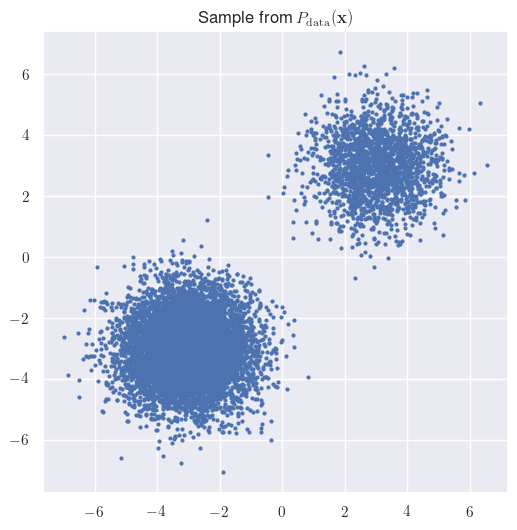

In [13]:
dataset2 = DataSet(dist1, dist2, probability=probability, total_len=10000)
dataloader2 = torch.utils.data.DataLoader(dataset2, batch_size = batch_size, drop_last = True)
dataiterator2 = iter(dataloader2)
true_samples = [dataset2.__getitem__(i) for i in range(len(dataset2))]
true_samples = torch.stack(true_samples, dim=0)

plt.figure(figsize=(6,6))
plt.scatter(true_samples[:,0],true_samples[:,1], s=4)
plt.title(r'Sample from $P_{\mathrm{data}}(\mathbf{x})$')

## REVERSE DIFFUSION PROCESS

In [66]:
def update_plot(i, data, scat):
    scat.set_offsets(data[i].detach().cpu().numpy())
    return scat

sampling_number = 10000
only_final = False
dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, n_steps, annealed_step, model, device, eps=eps)
sample = dynamic.sampling(sampling_number, only_final)
scatter(sample, only_final, scatter_range=scatter_range)

numframes = len(sample)
scatter_point = sample[0].detach().cpu().numpy()
scatter_x, scatter_y = scatter_point[:,0], scatter_point[:,1]

fig = plt.figure(figsize=(6, 6))
plt.xlim(scatter_range)
plt.ylim(scatter_range)
scat = plt.scatter(scatter_x, scatter_y, s=3)
plt.show()
clear_output()

ani = animation.FuncAnimation(fig, update_plot, frames=range(numframes), fargs=(sample, scat), interval=1000)
ani.save('./toy2d/toy2d.gif')
HTML(ani.to_jshtml())